## S&P Global - Well Logs 
### Misael M. Morales

In [1]:
from utils import *

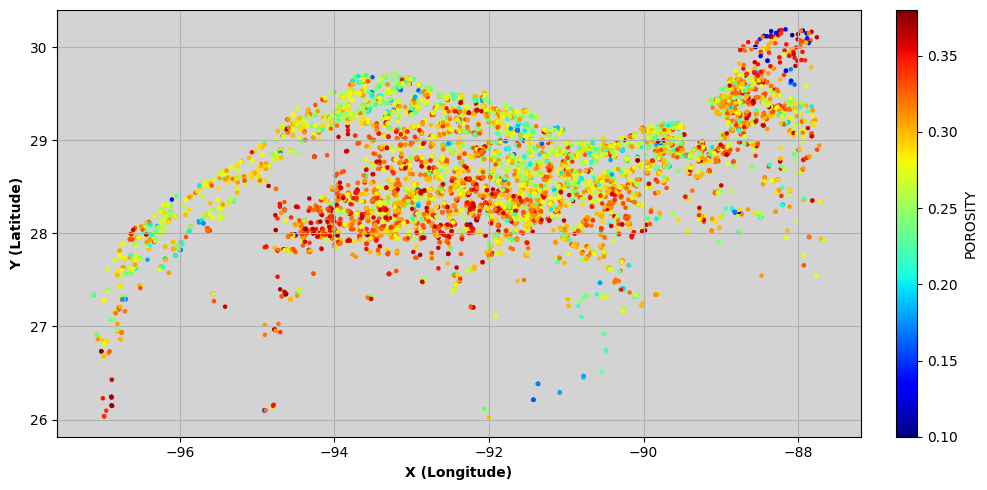

In [2]:
plot_ccs_sand_wells()

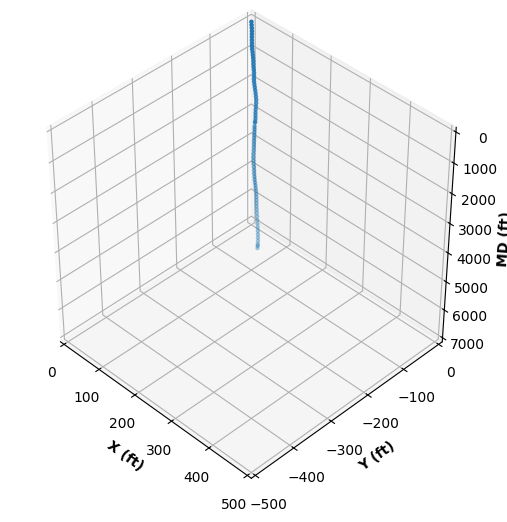

In [6]:
survey = pd.read_csv('Data/UT dir surveys/427064023000_DIRSUR_NAD27(USFEET)US-SPC27-EXACT(TX-27SC).TXT',skiprows=3, sep='\s+')
#survey = pd.read_csv('Data/UT dir surveys/177004037400_DIRSUR_NAD27(USFEET)US-SPC27-EXACT(LA-27S).TXT',skiprows=3, sep='\s+')
plot_survey(survey)

In [ ]:
headers = {}
k = 0
for root, dirs, files in os.walk('Data/UT Export 9-19'):
    for f in files:
        fname = os.path.join(root, f)
        df = lasio.read(fname).df()
        headers[k] = df.columns
        k += 1

dict_keys(['DEPT', 'ASN', 'CALI', 'DRHO', 'DT', 'GR', 'GR_NORM', 'ILD', 'RHOB', 'SP', 'SP_NORM', 'VSH_GR', 'VSH_SP'])


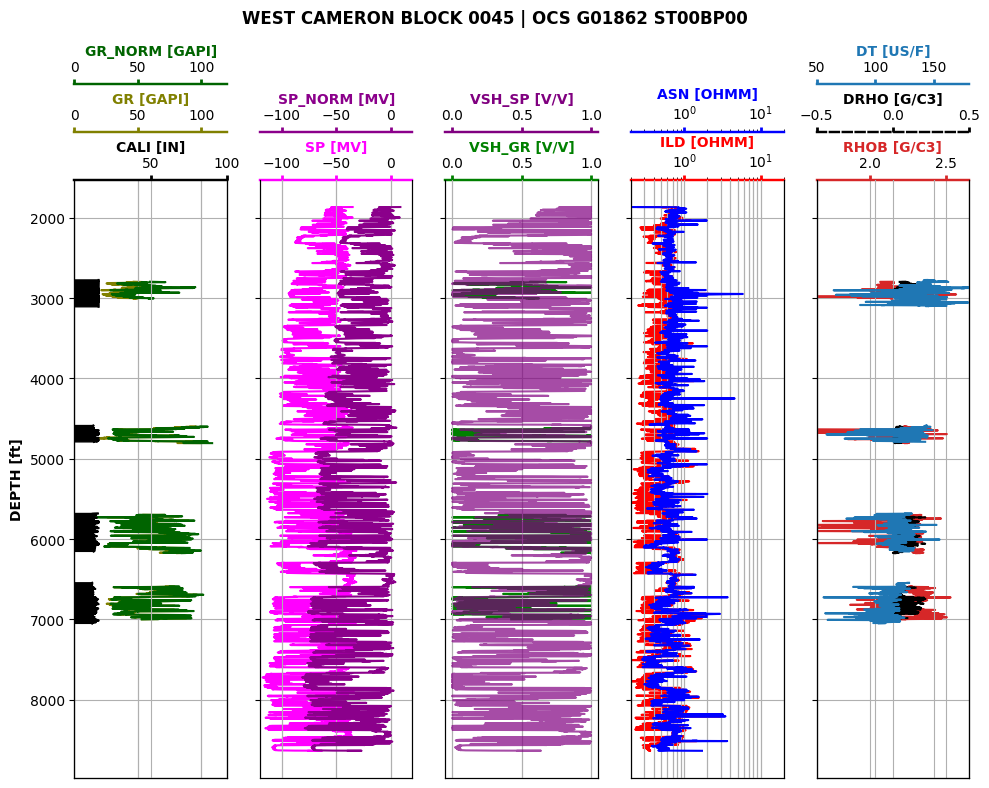

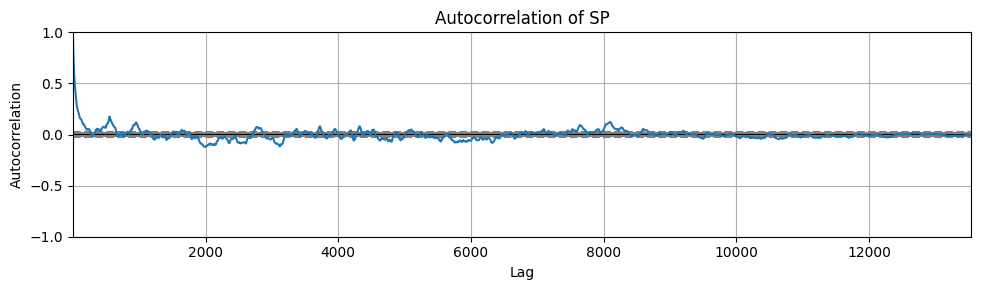

In [7]:
well_name = '17700004060000'
well_log = lasio.read('Data/UT Export 9-19/{}.las'.format(well_name))
well_name, well_field = well_log.header['Well']['WELL'].value, well_log.header['Well']['FLD'].value
print(well_log.curvesdict.keys())


fig, axs = plt.subplots(1, 5, figsize=(10, 8), sharey=True)
fig.suptitle('{} | {}'.format(well_field, well_name), weight='bold')
ax1, ax2, ax3, ax4, ax5 = axs.flatten()

ax11, ax12 = ax1.twiny(), ax1.twiny()
plot_curve(ax12, well_log, 'CALI', 0.1, 100, color='k', fill=True)
plot_curve(ax1, well_log, 'GR', 0, 120, color='olive', pad=1.08)
plot_curve(ax11, well_log, 'GR_NORM', 0, 120, color='darkgreen', pad=1.16)

ax21 = ax2.twiny()
plot_curve(ax2, well_log, 'SP', -120, 20, color='magenta')
plot_curve(ax21, well_log, 'SP_NORM', -120, 20, color='darkmagenta', pad=1.08)

ax31 = ax3.twiny()
plot_curve(ax3, well_log, 'VSH_GR', -0.05, 1.05, color='green')
plot_curve(ax31, well_log, 'VSH_SP', -0.05, 1.05, color='purple', alpha=0.7, pad=1.08)

ax41 = ax4.twiny()
plot_curve(ax4, well_log, 'ILD', 0.2, 20, color='r', semilog=True)
plot_curve(ax41, well_log, 'ASN', 0.2, 20, color='b', semilog=True, pad=1.08)

ax51, ax52 = ax5.twiny(), ax5.twiny()
plot_curve(ax5, well_log, 'RHOB', 1.65, 2.65, color='tab:red')
plot_curve(ax51, well_log, 'DRHO', -0.5, 0.5, color='k', linestyle='--', pad=1.08)
plot_curve(ax52, well_log, 'DT', 50, 180, color='tab:blue', pad=1.16)

ax1.set_ylabel('DEPTH [ft]', weight='bold')
plt.gca().invert_yaxis(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3))
pd.plotting.autocorrelation_plot(well_log['SP'])
plt.title('Autocorrelation of SP')
plt.tight_layout(); plt.show()

In [ ]:
model = ARIMA(well_log['SP'], order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))

mu, std = stats.norm.fit(model_fit.resid)
x = np.linspace(-20, 20, 500)
p = stats.norm.pdf(x, mu ,std)

ax2 = ax.twiny()
ax.plot(model_fit.resid, c='tab:blue', label='Residuals')
ax2.plot(p,x, c='tab:red', linewidth=3, label='PDF')
ax2.set_xticks([])

plt.title('ARIMA MODEL | Residuals', weight='bold')
plt.tight_layout(); plt.show()

***
# SP BASELINE CORRECTION
***

In [ ]:
### PRELOAD
logs = np.load('Data/log_data.npy')
print(logs.shape)

In [8]:
logs_list = {}
files = os.listdir('Data/UT Export 9-19/')
k = 0
for file in tqdm(files, desc='Processing Files', unit='file'):
    log = lasio.read('Data/UT Export 9-19/{}'.format(file))
    if 'SP' in log.curvesdict.keys() and 'SP_NORM' in log.curvesdict.keys():
        logs_list[k] = pd.DataFrame({'DEPT': log['DEPT'], 'SP': log['SP'], 'SP_NORM': log['SP_NORM']})
        k += 1

logs = np.zeros((len(logs_list),44055,3))
for i in range(len(logs_list)):
    logs[i,logs_list[i].index,:] = logs_list[i].values
logs = np.where(logs==0, np.nan, logs)

Processing Files: 100%|██████████| 438/438 [02:53<00:00,  2.53file/s]


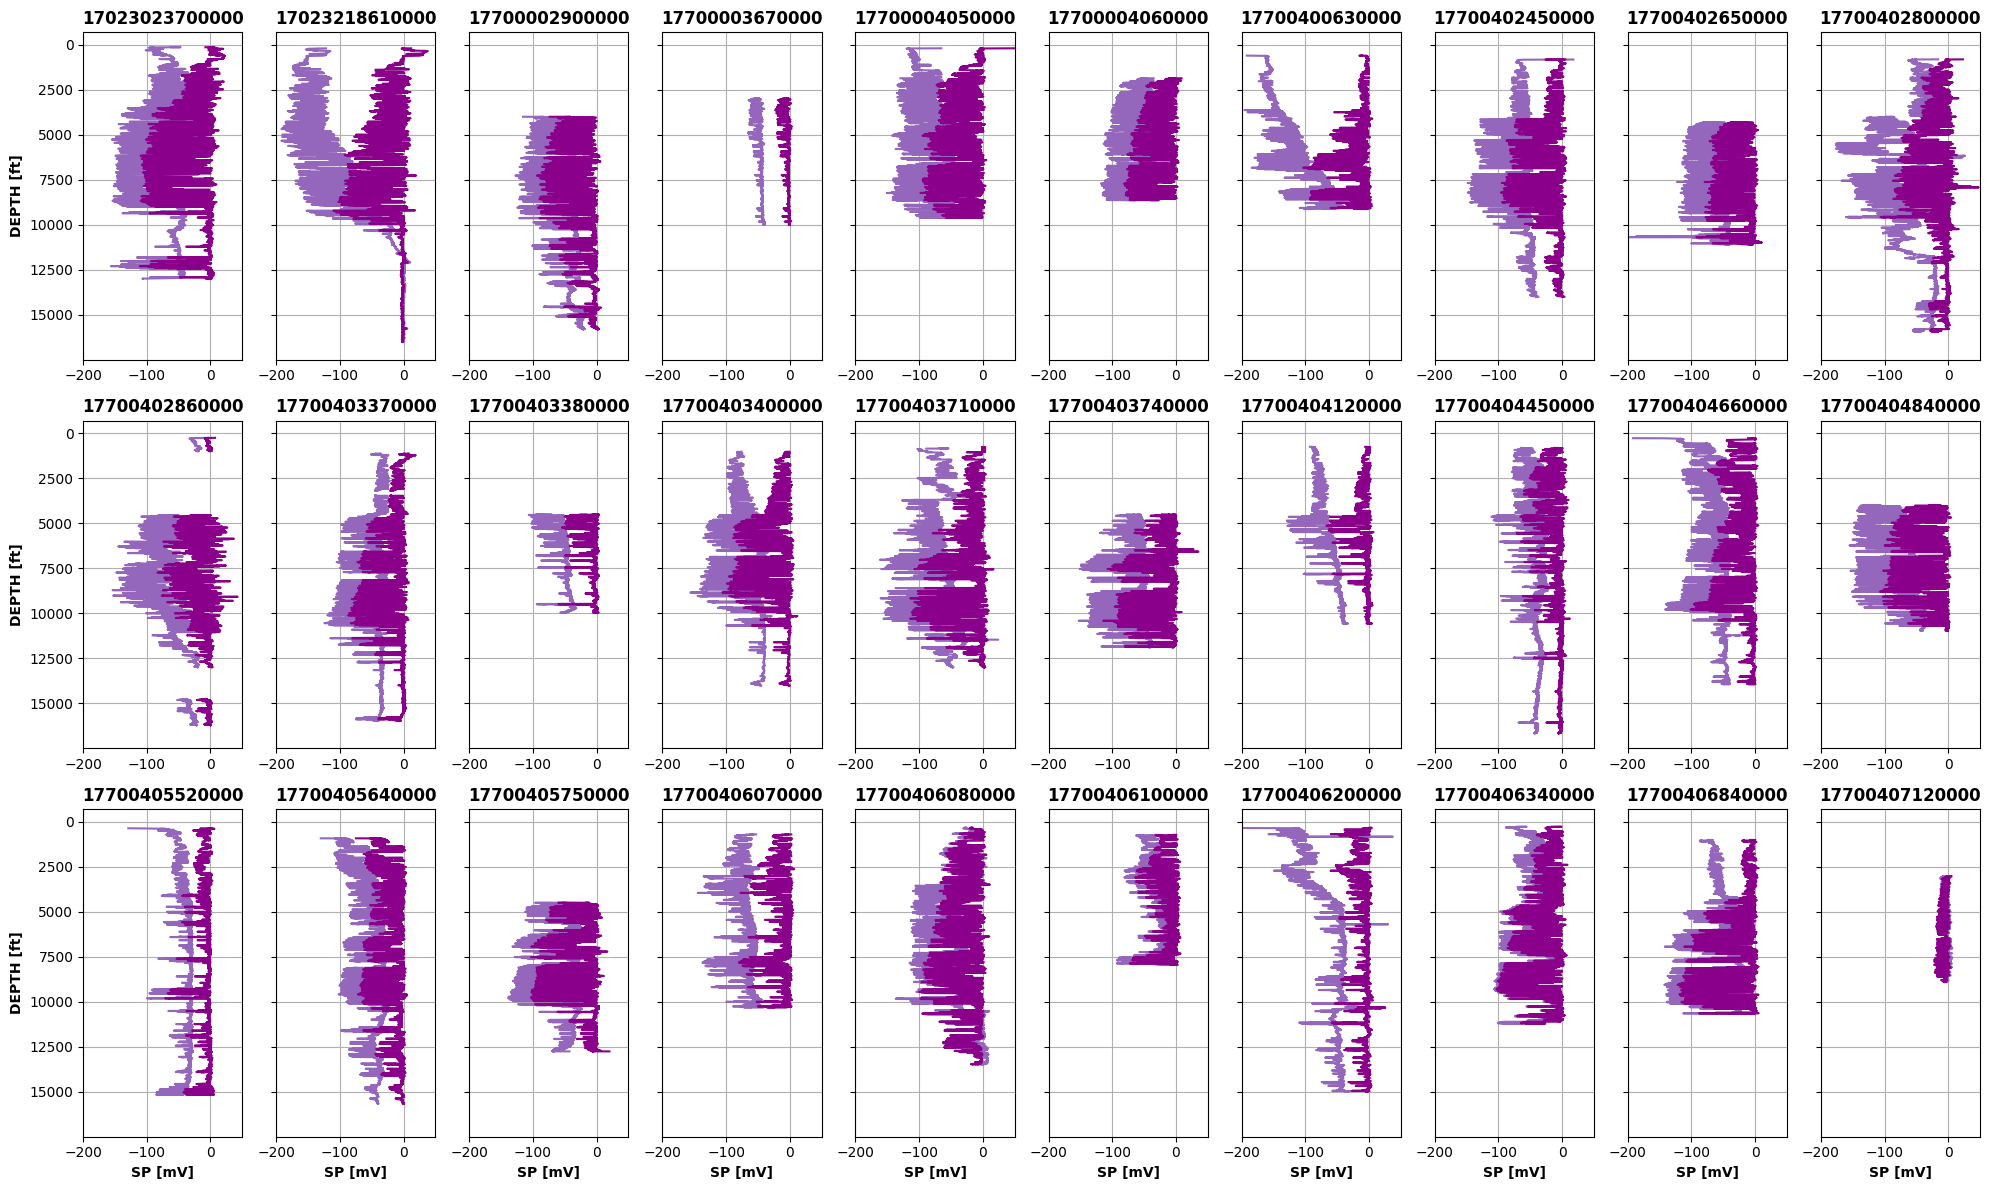

In [11]:
fig, axs = plt.subplots(3, 10, figsize=(20, 12), sharey=True)
k = 0
for i in range(3):
    for j in range(10):
        axs[i,j].plot(logs[k,:,1], logs[k,:,0], c='tab:purple', label='SP')
        axs[i,j].plot(logs[k,:,2], logs[k,:,0], c='darkmagenta', label='SP_NORM')
        axs[i,j].set_title(os.listdir('Data/UT Export 9-19/')[k].split('.')[0], weight='bold')
        axs[i,0].set_ylabel('DEPTH [ft]', weight='bold')
        axs[-1,j].set_xlabel('SP [mV]', weight='bold')
        axs[i,j].set_xlim(-200, 50)
        axs[i,j].grid(True, which='both')
        k += 1
#axs[-1,-1].legend(facecolor='wheat', edgecolor='k')
axs[0,0].invert_yaxis()
plt.tight_layout(); plt.show()

In [38]:
logs_clean = np.nan_to_num(logs, nan=0)
print(logs_clean.shape)

X_data = np.expand_dims(logs_clean[:,:,:2],-1)
y_data = np.expand_dims(np.expand_dims(logs_clean[:,:,-1],-1),-1)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.227)

print('X_train: {} | y_train: {}'.format(X_train.shape, y_train.shape))
print('X_test:  {}  | y_test:  {}'.format(X_test.shape, y_test.shape))

(389, 44055, 3)
X_train: (300, 44055, 2, 1) | y_train: (300, 44055, 1, 1)
X_test:  (89, 44055, 2, 1)  | y_test:  (89, 44055, 1, 1)


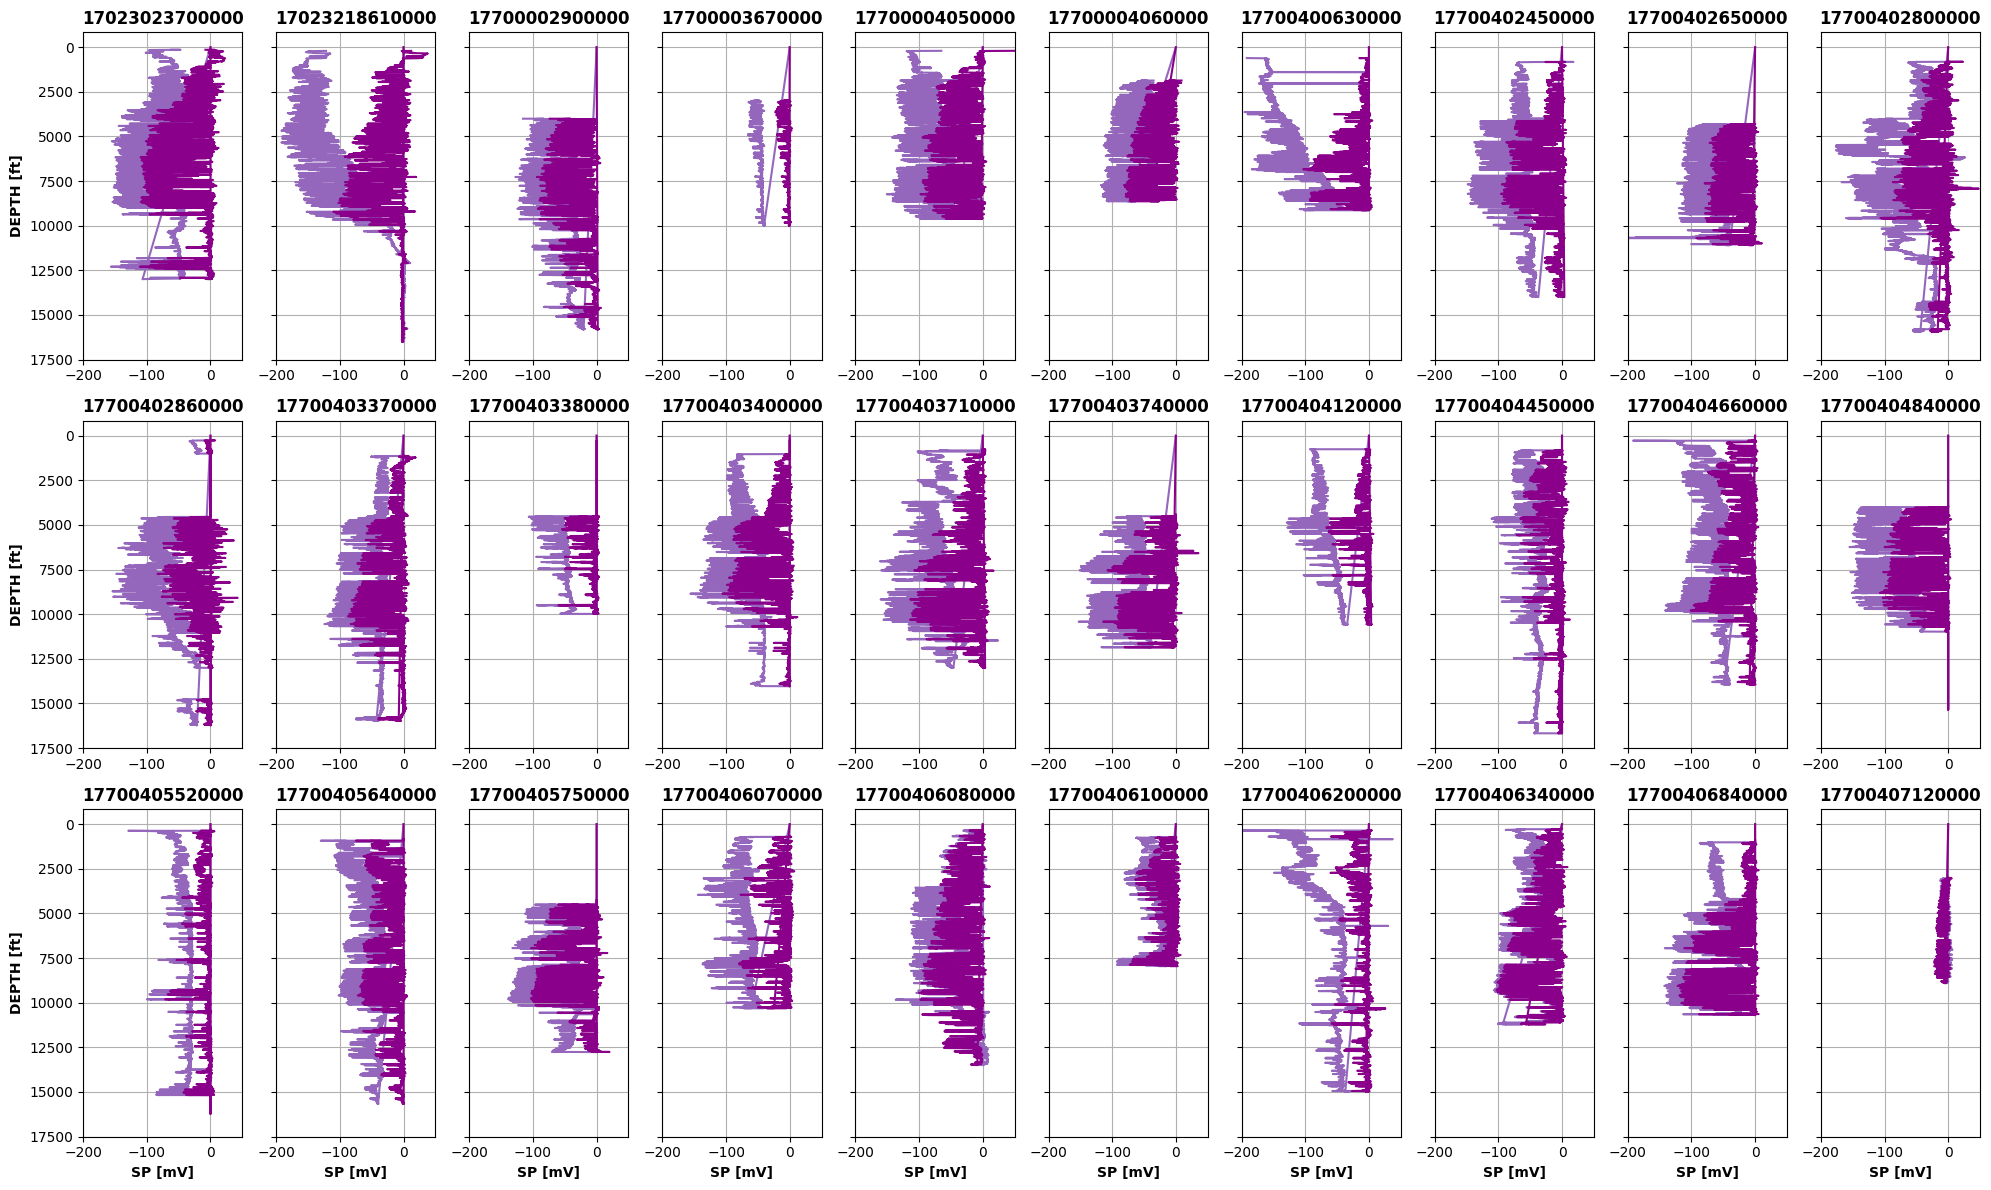

In [40]:
fig, axs = plt.subplots(3, 10, figsize=(20, 12), sharey=True)
k = 0
for i in range(3):
    for j in range(10):
        axs[i,j].plot(logs_clean[k,:,1], logs_clean[k,:,0], c='tab:purple', label='SP')
        axs[i,j].plot(logs_clean[k,:,2], logs_clean[k,:,0], c='darkmagenta', label='SP_NORM')
        axs[i,j].set_title(os.listdir('Data/UT Export 9-19/')[k].split('.')[0], weight='bold')
        axs[i,0].set_ylabel('DEPTH [ft]', weight='bold')
        axs[-1,j].set_xlabel('SP [mV]', weight='bold')
        axs[i,j].set_xlim(-200, 50)
        axs[i,j].grid(True, which='both')
        k += 1
#axs[-1,-1].legend(facecolor='wheat', edgecolor='k')
axs[0,0].invert_yaxis()
plt.tight_layout(); plt.show()

In [105]:
from keras import Model
from keras import optimizers
from keras import backend as K
from keras.layers import Input, LSTM, ConvLSTM1D, Conv1D, Conv1DTranspose, BatchNormalization, LeakyReLU, ReLU, MaxPooling1D, UpSampling1D
from keras.layers import Concatenate, Add, Reshape, Flatten, Dense, Dropout, ZeroPadding1D, Cropping1D, GlobalAveragePooling1D

def make_nn():
    K.clear_session()
    def enc_layer(inp, units):
        _ = Conv1D(units, 15, padding='same')(inp)
        _ = BatchNormalization()(_)
        _ = ReLU()(_)
        _ = MaxPooling1D(2)(_)
        return _
    
    def dec_layer(inp, units):
        _ = Conv1D(units, 15, padding='same')(inp)
        _ = BatchNormalization()(_)
        _ = ReLU()(_)
        _ = UpSampling1D(2)(_)
        return _
    
    inputs = Input(shape=(44055,2))

    x1 = enc_layer(inputs, 16)
    x2 = enc_layer(x1, 64)
    x3 = enc_layer(x2, 128)

    y3 = dec_layer(x3, 64)
    y2 = dec_layer(y3, 16)
    y1 = dec_layer(y2, 4)

    _ = ZeroPadding1D((4,3))(y1)
    _ = Conv1D(1, 15, padding='same')(_)

    return Model(inputs, _)

model = make_nn()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 44055, 2)]        0         
                                                                 
 conv1d (Conv1D)             (None, 44055, 16)         496       
                                                                 
 batch_normalization (Batch  (None, 44055, 16)         64        
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 44055, 16)         0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 22027, 16)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 22027, 64)         15424 

In [106]:
opt = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])
fit = model.fit(X_train, y_train, 
                epochs           = 100,
                batch_size       = 30,
                validation_split = 0.25,
                shuffle          = True,
                verbose          = 0)

2024-02-13 15:55:20.171003: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-13 15:55:20.440427: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2024-02-13 15:55:21.332285: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2024-02-13 15:55:23.823437: I external/local_xla/xla/service/service.cc:168] XLA service 0x2dacc1f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-13 15:55:23.823469: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-02-13 15:55:23.835417: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707861323.913234    5436 device_compiler.h:186] Compiled clus

In [125]:
from sklearn.metrics import mean_squared_error

In [126]:
y_train_pred = model.predict(X_train).squeeze().astype('float32')
y_test_pred  = model.predict(X_test).squeeze().astype('float32')
print('y_train_pred: {} | y_test_pred: {}'.format(y_train_pred.shape, y_test_pred.shape))

train_mse = mean_squared_error(y_train.squeeze().astype('float32'), y_train_pred)
test_mse  = mean_squared_error(y_test.squeeze().astype('float32'), y_test_pred)
print('Train MSE: {:.4f} | Test MSE: {:.4f}'.format(train_mse, test_mse))

3/3 [==============================] - 0s 30ms/step
y_train_pred: (300, 44055) | y_test_pred: (89, 44055)
Train MSE: 42.2437 | Test MSE: 58.2782


In [129]:
X_train, X_test, y_train, y_test = X_train.squeeze(), X_test.squeeze(), y_train.squeeze(), y_test.squeeze()
print('X_train: {} | y_train: {}'.format(X_train.shape, y_train.shape))
print('X_test:  {}  | y_test:  {}'.format(X_test.shape, y_test.shape))

X_train: (300, 44055, 2) | y_train: (300, 44055)
X_test:  (89, 44055, 2)  | y_test:  (89, 44055)


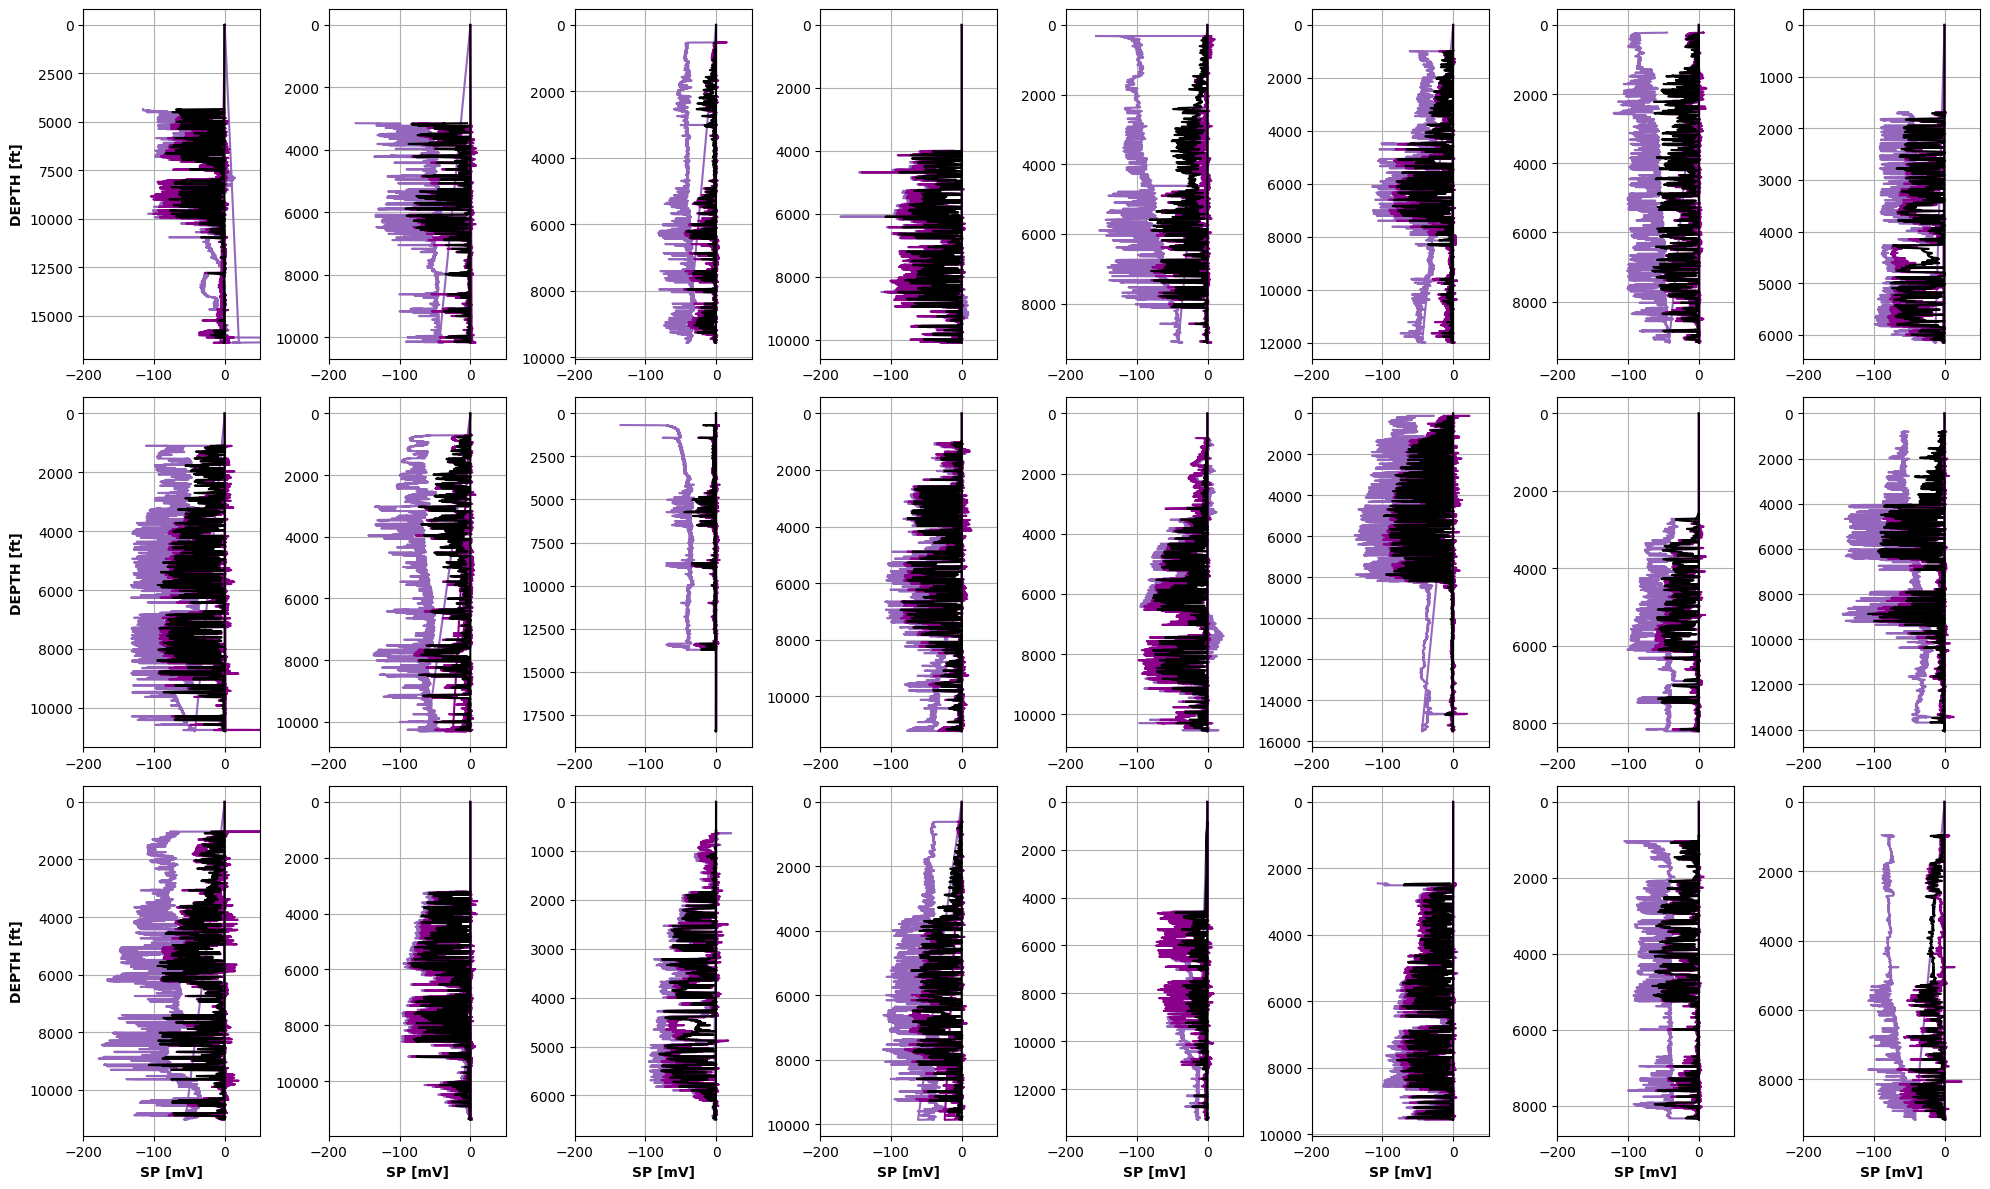

In [161]:
nrows, ncols = 3, 8
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 12))
k, mult = 0, 5
for i in range(nrows):
    for j in range(ncols):

        mask = ~np.isnan(X_train[k,:,0])
        index = X_train[k,:,0][mask]
        x  = X_train[k,:,1][mask]
        y  = y_train[k][mask]
        yh = y_train_pred[k][mask]

        axs[i,j].plot(x, index, c='tab:purple', label='SP')
        axs[i,j].plot(y, index, c='darkmagenta', label='True Corr.')
        axs[i,j].plot(yh, index, c='k', label='Pred Corr.')

        axs[i,0].set_ylabel('DEPTH [ft]', weight='bold')
        axs[-1,j].set_xlabel('SP [mV]', weight='bold')
        axs[i,j].set_xlim(-200, 50)
        axs[i,j].grid(True, which='both')
        axs[i,j].invert_yaxis()
        k += 1*mult

plt.tight_layout(); plt.show()

***
# END